### initialisation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!pip install munch
!pip install ffmpeg

In [16]:
cd drive/MyDrive/streetviewGan/29-03-2022/

/content/drive/MyDrive/streetviewGan/29-03-2022


In [ ]:
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import torch.nn.functional as F
import pickle
import torch
import pandas as pd
from torchvision import transforms
from sklearn.model_selection import train_test_split

import numpy as np
from torch.autograd import Variable
import torch
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

### functions

In [ ]:
import pathlib
import os
from skimage import io
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import skimage
import torch.nn.functional as F
from torchvision import transforms


class HousePriceDataset(Dataset):
    """house price dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        df = pd.read_csv(csv_file)

        df3 = df

        df3["tree"] = (df3["tree"] - np.mean(df3["tree"])) / np.std(df3["tree"])
        df3["building"] = (df3["building"] - np.mean(df3["building"])) / np.std(
            df3["building"]
        )
        df3["sky"] = (df3["sky"] - np.mean(df3["sky"])) / np.std(df3["sky"])
        df3["road"] = (df3["road"] - np.mean(df3["road"])) / np.std(df3["road"])
        df3["residuals"] = (df3["residuals"] - np.mean(df3["residuals"])) / np.std(
            df3["residuals"]
        )
        df3["enclosure"] = (df3["enclosure"] - np.mean(df3["enclosure"])) / np.std(
            df3["enclosure"]
        )

        df3 = df3.sort_values(by=["ID"])
        df3 = df3[:20000]
        df3 = df3.reset_index()
        del df3["index"]

        print("HousePrice Dataset size:", len(df3.index))

        self.dataframe = df3
        self.root_dir = root_dir
        # self.orig_dir = orig_dir
        # self.perturb_dir=perturb_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, str(self.dataframe.loc[idx, "ID"]))
        image = io.imread(img_name + ".jpg")
        labels1 = self.dataframe.loc[idx, "tree"]
        labels1 = np.array([labels1])
        labels2 = self.dataframe.loc[idx, "building"]
        labels2 = np.array([labels2])
        labels3 = self.dataframe.loc[idx, "road"]
        labels3 = np.array([labels3])
        labels4 = self.dataframe.loc[idx, "sky"]
        labels4 = np.array([labels4])
        labels5 = self.dataframe.loc[idx, "enclosure"]
        labels5 = np.array([labels5])
        labels6 = self.dataframe.loc[idx, "ID"]
        labels6 = np.array([labels6])
        labels7 = self.dataframe.loc[idx, "residuals"]
        labels7 = np.array([labels7])
        # landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {
            "image": image,
            "labels1": labels1,
            "labels2": labels2,
            "labels3": labels3,
            "labels4": labels4,
            "labels5": labels5,
            "labels6": labels6,
            "labels7": labels7,
        }
        if self.transform:
            sample = self.transform(sample)

        return sample


class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, labels1, labels2, labels3, labels4, labels5, labels6, labels7 = (
            sample["image"],
            sample["labels1"],
            sample["labels2"],
            sample["labels3"],
            sample["labels4"],
            sample["labels5"],
            sample["labels6"],
            sample["labels7"],
        )

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = skimage.transform.resize(image, (new_h, new_w))

        return {
            "image": img,
            "labels1": labels1,
            "labels2": labels2,
            "labels3": labels3,
            "labels4": labels4,
            "labels5": labels5,
            "labels6": labels6,
            "labels7": labels7,
        }


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, labels1, labels2, labels3, labels4, labels5, labels6, labels7 = (
            sample["image"],
            sample["labels1"],
            sample["labels2"],
            sample["labels3"],
            sample["labels4"],
            sample["labels5"],
            sample["labels6"],
            sample["labels7"],
        )

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {
            "image": torch.from_numpy(image),
            "labels1": torch.from_numpy(labels1),
            "labels2": torch.from_numpy(labels2),
            "labels3": torch.from_numpy(labels3),
            "labels4": torch.from_numpy(labels4),
            "labels5": torch.from_numpy(labels5),
            "labels6": torch.from_numpy(labels6),
            "labels7": torch.from_numpy(labels7),
        }


class Normalize(object):
    """normalize image array"""

    def __init__(self):
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
        self.transform = transforms.Normalize(mean, std, False)

    def __call__(self, sample):
        image, labels1, labels2, labels3, labels4, labels5, labels6, labels7 = (
            sample["image"],
            sample["labels1"],
            sample["labels2"],
            sample["labels3"],
            sample["labels4"],
            sample["labels5"],
            sample["labels6"],
            sample["labels7"],
        )

        image = self.transform(image)

        return {
            "image": image,
            "labels1": labels1,
            "labels2": labels2,
            "labels3": labels3,
            "labels4": labels4,
            "labels5": labels5,
            "labels6": labels6,
            "labels7": labels7,
        }


class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor


In [ ]:
import torch
from torch import nn

def defineGanVAEModel1():
    class Encoder(nn.Module):
        def __init__(self):
            super(Encoder, self).__init__()
            self.encoder = nn.Sequential(
                nn.Conv2d(3, 64, kernel_size=3, padding=1),
                nn.ReLU(True),
                nn.InstanceNorm2d(64),
                nn.Conv2d(64, 64, kernel_size=3, padding=1),
                nn.ReLU(True),
                nn.InstanceNorm2d(64),
                nn.MaxPool2d(2, stride=2),  # b, 16, 5, 5
                nn.Conv2d(64, 64, kernel_size=3, padding=1),
                nn.ReLU(True),
                nn.InstanceNorm2d(64),
                nn.Conv2d(64, 64, kernel_size=3, padding=1),
                nn.ReLU(True),
                nn.InstanceNorm2d(64),
                nn.MaxPool2d(2, stride=2),  # b, 16, 5, 5
                nn.Conv2d(64, 64, kernel_size=3, padding=1),
                nn.ReLU(True),
                nn.InstanceNorm2d(64),
                nn.Conv2d(64, 64, kernel_size=3, padding=1),
                nn.ReLU(True),
                nn.InstanceNorm2d(64),
                nn.MaxPool2d(2, stride=2),
                nn.Conv2d(64, 64, kernel_size=3, padding=1),
                nn.ReLU(True),
                nn.InstanceNorm2d(64),
                nn.Conv2d(64, 64, kernel_size=3, padding=1),
                nn.ReLU(True),
                nn.InstanceNorm2d(64),
                nn.MaxPool2d(2, stride=2),
                nn.Flatten(),
            )
            self.mu = nn.Linear(64 * 14 * 14, 1568)
            self.var = nn.Linear(64 * 14 * 14, 1568)

        def forward(self, x):
            x = self.encoder(x)
            z_mu = self.mu(x)
            z_var = self.var(x)
            return z_mu, z_var

    class Decoder(nn.Module):
        def __init__(self):
            super(Decoder, self).__init__()
            self.latent_to_hidden = nn.Linear(1568, 64 * 14 * 14)  # + n_classes
            self.decoder = nn.Sequential(
                nn.UpsamplingNearest2d(scale_factor=2),
                nn.ReflectionPad2d(1),
                nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=0),
                nn.ReLU(True),
                nn.InstanceNorm2d(64),
                nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
                nn.ReLU(True),
                nn.InstanceNorm2d(64),
                nn.UpsamplingNearest2d(scale_factor=2),
                nn.ReflectionPad2d(1),
                nn.Conv2d(
                    64, 64, kernel_size=3, stride=1, padding=0
                ),  # ,output_padding=1),
                nn.ReLU(True),
                nn.InstanceNorm2d(64),
                nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
                nn.ReLU(True),
                nn.InstanceNorm2d(64),
                nn.UpsamplingNearest2d(scale_factor=2),
                nn.ReflectionPad2d(1),
                nn.Conv2d(
                    64, 64, kernel_size=3, stride=1, padding=0
                ),  # ,output_padding=1),
                nn.ReLU(True),
                nn.InstanceNorm2d(64),
                nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
                nn.ReLU(True),
                nn.InstanceNorm2d(64),
                nn.UpsamplingNearest2d(scale_factor=2),
                nn.ReflectionPad2d(1),
                # ,output_padding=1),
                nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=0),
            )  # nn.Sigmoid()

        def forward(self, x):
            x = self.latent_to_hidden(x)
            x = x.view(-1, 64, 14, 14)
            x = self.decoder(x)
            return x

    class VAE(nn.Module):
        def __init__(self):
            super().__init__()
            self.encoder = Encoder()  # .cuda()#, n_classes)
            self.decoder = Decoder()  # .cuda()#, n_classes)

        def forward(self, x):
            # encode
            z_mu, z_var = self.encoder(x)

            # sample from the distribution having latent parameters z_mu, z_var
            # reparameterize
            std = torch.exp(z_var / 2)
            eps = torch.randn_like(std)
            x_sample = eps.mul(std).add_(z_mu)

            # decode
            predicted = self.decoder(x_sample)
            return predicted, z_mu, z_var

    device = torch.device("cpu")
    model = VAE().to(device)

    class Discriminator(nn.Module):
        def __init__(self):
            super(Discriminator, self).__init__()
            self.discriminator = nn.Sequential(
                nn.Conv2d(3, 28, kernel_size=3, padding=1),
                nn.ReLU(True),
                nn.InstanceNorm2d(64),
                nn.MaxPool2d(2, stride=2),
                nn.Conv2d(28, 36, kernel_size=3, padding=1),
                nn.ReLU(True),
                nn.InstanceNorm2d(64),
                nn.MaxPool2d(2, stride=2),
                nn.Conv2d(36, 48, kernel_size=3, padding=1),
                nn.ReLU(True),
                nn.InstanceNorm2d(128),
                nn.MaxPool2d(2, stride=2),
                nn.Conv2d(48, 64, kernel_size=3, padding=1),
                nn.ReLU(True),
                nn.InstanceNorm2d(64),
                nn.MaxPool2d(2, stride=2),
                nn.Conv2d(64, 64, kernel_size=3, padding=1),
                nn.ReLU(True),
                nn.InstanceNorm2d(64),
                nn.MaxPool2d(2, stride=2),
                nn.Flatten(),
                nn.Linear((64 * 7 * 7), (1), bias=True),
                # nn.Flatten(),
                # nn.Linear((64*7*7), (1)),
                # nn.ReLU(),
                # nn.Linear((32), (1)),
                nn.Sigmoid(),
            )

        def forward(self, x):
            x = self.discriminator(x)
            return x

    discriminator = Discriminator()  # .cuda()

    return model, discriminator  # encoder,decoder




In [ ]:
import numpy as np


def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.25
    x -= x.mean()
    x /= x.std() + 10 ** (-10)
    x *= 0.25

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype("uint8")
    return x

In [ ]:
from torch import optim
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm

def define_simple_regressor(num_comp):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    eval_model = nn.Sequential(
      nn.Linear(num_comp, 1),
      ).to(device)
    return eval_model

In [ ]:
def squared_loss(fac, cfc):
    return (fac - cfc) ** 2

def lagrangian(res, tgt):
    return (res - tgt) ** 2

def counterfactual_regressor_only(
    x,
    y,
    #latent_pos,
    target,
    regressor,
    new_L=False,
    lambda_target=1,
    lr=1,
    iterations=5000,
):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    y = np.asarray(y)
    y = np.expand_dims(y, axis=1)
    target = np.array(target)
    target = Variable(torch.from_numpy(target), requires_grad=False).float().to(device)
    #latent_pos = (
    #    Variable(torch.from_numpy(latent_pos), requires_grad=False).to(device).float()
    #)

    pca_dims = x.shape[1]
    curr_L = Variable(torch.from_numpy(x), requires_grad=False).to(device)
    if new_L is False:
        new_L = Variable(
            torch.randn(curr_L.shape).double().to(device) / 1.0e5 + curr_L.double(),
            requires_grad=True,
        )
    else:
        new_L = Variable(new_L, requires_grad=True)
    new_L.to(device)

    # set up loss and optimiser
    l1 = torch.nn.L1Loss().to(device)
    optimizer = torch.optim.ASGD(
        [
            new_L,
        ],
        lr=lr,
        t0=100,
        weight_decay=1e-5,
    )

    imgs = Variable(
        torch.empty([x.shape[0], 3, 244, 244], device=device, requires_grad=False),
        requires_grad=False,
    )
    distance = torch.empty([1], device=device, requires_grad=False)
    target_loss = torch.empty([1], device=device, requires_grad=False)
    loss = torch.empty([1], device=device, requires_grad=False)
    regression_result = torch.empty_like(target, device=device, requires_grad=False)

    optimizer.zero_grad(True)
    writer = SummaryWriter()

    for i in tqdm(range(iterations)):
        regression_result = regressor(new_L.float())
        target_loss = lambda_target * (
            lagrangian(tgt=target, res=regression_result).mean()
        )
        distance = l1(new_L.double(), curr_L.double())
        loss = distance + target_loss

        writer.add_scalars(
            "loss",
            {
                "total": loss,
                "distance": distance,
                "target": target_loss,
                "regression_0": regression_result[0],
            },
            i + 1,
        )

        if i % 200 == 0:
            print(
                f"""
                Iteration: {i}
                Loss: {loss.item()}
                The current distance is: {distance.item()}
                The current penalty is: {target_loss.item()}
            """
            )

        optimizer.zero_grad(True)
        loss.backward(retain_graph=True)
        optimizer.step()

        #latent_pos = latent_pos.detach()

    return new_L




In [ ]:
def counterfactuals_latregressor_only(
    df,
    cf_idx,
    sType,
    target,
    lat_dim,
    latentcoef,
    regression_model,
    iterations=20_000,
    lr=0.001,
    lambda_target=100,
    ):
    
    response=['lv_'+str(i) for i in latentcoef]
    #latent_pos = np.asarray(df[response])[cf_idx]


    X = df[response]
    y = df[sType]
    X = np.asarray(X)

    cf_x = X[cf_idx]
    cf_y = y[cf_idx]
    
    df2 = None
    counterfactuals = counterfactual_regressor_only(
            cf_x,
            cf_y,
            #latent_pos,
            target,
            regression_model,
            new_L=False,
            lambda_target=lambda_target,
            lr=lr,
            iterations=iterations,
            )
        
    df2 = df.loc[cf_idx]
    df2.reset_index(drop=True, inplace=True)
    cfDF = pd.DataFrame(counterfactuals.detach().cpu().numpy())
    cfDF.columns = cf_names
    df2 = pd.concat([df2, cfDF], axis=1)

    return df2

In [ ]:
def load_data(batch_size=10, num_workers=4):
  path = "../29-03-2022/vae_reg/vae_model2/df3_pca_all.csv"
  df = pd.read_csv(path)
  del df["Unnamed: 0"]
  transformed_dataset = HousePriceDataset(
      csv_file="../29-03-2022/dataset/GLA_residuals03B.csv",
      root_dir="../../../../All_street_photos/",
      transform=transforms.Compose(
          [
              Rescale(224),
              ToTensor(),
          ]
      ),
  )

  return df, transformed_dataset

def load_stargan():
  stargan = load_fitted_stargan() #starganSampler.load_fitted_stargan()
  return stargan

def init_vaegan(use_pretrained_vaegan):
  model, _discriminator = defineGanVAEModel1()#vaegan.defineGanVAEModel1()
  if use_pretrained_vaegan:
      path = "../29-03-2022/vae_reg/vae_model2/Lon_St_VAE_model.pth"
      model.load_state_dict(torch.load(path, map_location=device))
  else:
      print("I need data to train the VAEGAN")
      return None
  model.to(device)
  model.requires_grad = False
  model.eval()

  encoder = model.encoder
  decoder = model.decoder
  return encoder, decoder

def init_latregressor(df, sType, perturb_dim, use_pretrained_house_price_regressor,latentcoef,freezeList=None):
    path = f"HousepriceRegressor/{sType}_{perturb_dim}.pth"
    if use_pretrained_house_price_regressor:
      eval_model = define_simple_regressor(perturb_dim) #houseprice_regression.define_simple_regressor(perturb_dim)
      eval_model.load_state_dict(torch.load(path))
      eval_model.to(device)
    else:
      pass

    eval_model.requires_grad = False
    eval_model.eval()
    return eval_model




In [ ]:
import pathlib
# This is a bad hack but just want this to work initially
import sys
#curPath = str(pathlib.Path(__file__).parent.absolute())
curPath = 'stargan'
sys.path.append(curPath+'/starganV2')

from stargan.starganV2 import main
from types import SimpleNamespace


def load_fitted_stargan():
    # This is the set of arguments used when we trained the stargan
    # might need to be modified later
    args = {'img_size': 256, 'num_domains': 2, 'latent_dim': 16, 'hidden_dim':
            256, 'style_dim': 16, 'lambda_reg': 1, 'lambda_cyc': 1,
            'lambda_sty': 1, 'lambda_ds': 1, 'ds_iter': 100000, 'w_hpf': 0.0,
            'randcrop_prob': 0.5, 'total_iters': 100000, 'resume_iter': 95000,
            'batch_size': 8, 'val_batch_size': 32, 'lr': 0.0001, 'f_lr': 1e-06,
            'beta1': 0.0, 'beta2': 0.99, 'weight_decay': 0.0001,
            'num_outs_per_domain': 10, 'mode': 'eval', 'num_workers': 4,
            'seed': 777, 'train_img_dir': 'data/streetviews2/database/',
            'val_img_dir': 'data/streetviews_eval/database/', 'sample_dir':
            'expr/samples', 'checkpoint_dir': 'stargan/checkpoints/',
            'eval_dir': 'expr/run3/eval/', 'result_dir': 'expr/results',
            'src_dir': 'assets/representative/celeba_hq/src', 'ref_dir':
            'assets/representative/celeba_hq/ref', 'inp_dir':
            'assets/representative/custom/female', 'out_dir':
            'assets/representative/celeba_hq/src/female', 'wing_path':
            'expr/checkpoints/wing.ckpt', 'lm_path':
            'expr/checkpoints/celeba_lm_mean.npz', 'print_every': 10,
            'sample_every': 5000, 'save_every': 10000, 'eval_every': 50000}
    args = SimpleNamespace(**args)

    solver = main.Solver(args)
    nets_ema = solver.nets_ema
    resume_iter = args.resume_iter
    solver._load_checkpoint(args.resume_iter)
    return nets_ema


### main script

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
typeList = [
        "tree",
        "building",
        "sky",
        ]
        
lat_dim = 1568
responseAll = [str(i) for i in range(lat_dim)]
cf_names = [f"CF_{i}" for i in range(lat_dim)]
#aug_count = 1
latAll=['lv_'+str(i) for i in np.arange(0,lat_dim)]
response=['lv_'+str(i) for i in responseAll]
cf_names = [f"CF_{i}" for i in responseAll]
sType="tree"
s = typeList.index(sType)
target = 2.5


df, transformed_dataset = load_data()
dataloader = torch.utils.data.DataLoader(
        transformed_dataset, batch_size=40, num_workers=4
    )
encoder, decoder = init_vaegan(use_pretrained_vaegan=True)
stargan = load_stargan()

In [ ]:
path = '../29-03-2022/vae_reg/vae_model2/28-06-2022/df_zAll.csv'
df2 = pd.read_csv(path)
del df2["Unnamed: 0"]
colnames=[]
colnames.append('ID')
for i in np.arange(0,lat_dim):
  colnames.append('lv_'+str(i))
df2.columns=colnames
df3=pd.merge(df,df2,left_on='ID',right_on='ID')
df=df3

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=717)
use_pretrained_house_price_regressor=True
regression_model = init_latregressor(df_train, 
                                    sType, 
                                    lat_dim, 
                                    use_pretrained_house_price_regressor,
                                    responseAll,
                                     )

In [ ]:
response=['lv_'+str(i) for i in latentcoef]
#latent_pos = np.asarray(df[response])[cf_idx]


X = df[response]
y = df[sType]
X = np.asarray(X)

cf_x = X[cf_idx]
cf_y = y[cf_idx]

In [ ]:
cf_x

array([[ 0.30673158,  0.61160713, -5.74963188, ..., -2.49475098,
         0.73414409,  1.36566675]])

In [ ]:
#n = 1
#k = 1
#listofImages=[i for i in range(n, n + k)]
#sType="tree"

#for i in listofImages:
i=1
cf_idx=[i]
#latent_pos = np.asarray(df[response])[cf_idx]

X = df[response]
y = df[sType]
X = np.asarray(X)

cf_x = X[cf_idx]
cf_y = y[cf_idx]

df2 = counterfactuals_latregressor_only(
        df,
        cf_idx,
        sType,
        target,
        lat_dim,
        responseAll,
        regression_model,
        iterations=20_000,
        lambda_target=100,
        lr=0.001,
        )

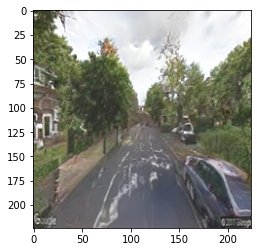

In [ ]:
#latAll=['lv_'+str(i) for i in np.arange(0,lat_dim)]
#response=['lv_'+str(i) for i in responseAll]
#responseAll=[i for i in responseAll]
#cf_names = [f"CF_{i}" for i in responseAll]
x=np.asarray(df2[cf_names].copy(), dtype="float64")
x = torch.from_numpy(x).float().to(device)
img = decoder.float()(x.float())
img = F.interpolate(img, size=224)
trg_idx = 0
y_trg = torch.tensor([trg_idx] * 1).to(device)
z_trg = torch.randn(1, 16).to(device)
s_trg = stargan.mapping_network(z_trg, y_trg)
masks = None
recon = stargan.generator(img, s=s_trg, masks=masks)
recon=recon.cpu().detach().numpy().squeeze().transpose(1,2,0)
recon = deprocess_image(recon)
plt.imshow(recon)

## publication code

### setting up - not to be sent

In [ ]:
# not to be sent for publication
lat_dim=1568
X=rand(lat_dim) # random inputs
X=np.expand_dims(X,0)
y=rand(1) 
np.save('testX.npy', X)    # .npy extension is added if not given
X = np.load('testX.npy')
np.save('testy.npy', y)    # .npy extension is added if not given
y = np.load('testy.npy')

# train regression model
optimizer = optim.Adam(regression_model.parameters(), lr=0.001, weight_decay=1e-5)
epochs=1000
criterion = torch.nn.MSELoss()
for param in regression_model.parameters():
    param.requires_grad = True 
torch.set_grad_enabled(True)
X=torch.from_numpy(X)
y=torch.from_numpy(y)
for epoch in tqdm(range(epochs), desc="Training regressor"):
    optimizer.zero_grad()
    outputs = regression_model(X.float().cuda())
    loss = criterion(outputs, y.float().cuda())
    loss.backward()
    optimizer.step()
PATH = "publications/test_VAE_model.pth" 
torch.save(model.state_dict(), PATH)
PATH = "publications/test_REG_model.pth"
torch.save(regression_model.state_dict(), PATH)

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
cd drive/MyDrive/streetviewGan/29-03-2022/

/content/drive/MyDrive/streetviewGan/29-03-2022


### publication code - to be sent

In [7]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
This is the anonymised private code submission for Manuscript ID IJGIS-2022-0537 entitled 
"Explaining Holistic Image Classifiers in Urban Analytics with Plausible Counterfactuals in urban analytics"  
to the International Journal of Geographical Information Science.
As the data cannot be redistributed due to commercial license, a set of simulated data and models have been used instead.  
"""

from torch import optim
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.autograd import Variable
from numpy.random import rand
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

In [14]:
def lagrangian(res, tgt):
    return (res - tgt) ** 2

def counterfactual_regressor_only(
    x,
    y,
    target,
    regressor,
    new_L=False,
    lambda_target=1,
    lr=1,
    iterations=5000,
):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    y = np.asarray(y)
    y = np.expand_dims(y, axis=1)
    target = np.array(target)
    target = Variable(torch.from_numpy(target), requires_grad=False).float().to(device)

    curr_L = Variable(torch.from_numpy(x), requires_grad=False).to(device)
    if new_L is False:
        new_L = Variable(
            torch.randn(curr_L.shape).double().to(device) / 1.0e5 + curr_L.double(),
            requires_grad=True,
        )
    else:
        new_L = Variable(new_L, requires_grad=True)
    new_L.to(device)

    l1 = torch.nn.L1Loss().to(device)
    optimizer = torch.optim.ASGD(
        [
            new_L,
        ],
        lr=lr,
        t0=100,
        weight_decay=1e-5,
    )

    imgs = Variable(
        torch.empty([x.shape[0], 3, 244, 244], device=device, requires_grad=False),
        requires_grad=False,
    )
    distance = torch.empty([1], device=device, requires_grad=False)
    target_loss = torch.empty([1], device=device, requires_grad=False)
    loss = torch.empty([1], device=device, requires_grad=False)
    regression_result = torch.empty_like(target, device=device, requires_grad=False)

    optimizer.zero_grad(True)

    for i in tqdm(range(iterations)):
        regression_result = regressor(new_L.float())
        target_loss = lambda_target * (
            lagrangian(tgt=target, res=regression_result).mean()
        )
        distance = l1(new_L.double(), curr_L.double())
        loss = distance + target_loss
        optimizer.zero_grad(True)
        loss.backward(retain_graph=True)
        optimizer.step()

    return new_L

In [9]:
def defineVAEModel1():
    class Encoder(nn.Module):
        def __init__(self):
            super(Encoder, self).__init__()
            self.encoder = nn.Sequential(
                nn.Conv2d(3, 64, kernel_size=3, padding=1),
                nn.ReLU(True),
                nn.InstanceNorm2d(64),
                nn.Conv2d(64, 64, kernel_size=3, padding=1),
                nn.ReLU(True),
                nn.InstanceNorm2d(64),
                nn.MaxPool2d(2, stride=2),  # b, 16, 5, 5
                nn.Conv2d(64, 64, kernel_size=3, padding=1),
                nn.ReLU(True),
                nn.InstanceNorm2d(64),
                nn.Conv2d(64, 64, kernel_size=3, padding=1),
                nn.ReLU(True),
                nn.InstanceNorm2d(64),
                nn.MaxPool2d(2, stride=2),  # b, 16, 5, 5
                nn.Conv2d(64, 64, kernel_size=3, padding=1),
                nn.ReLU(True),
                nn.InstanceNorm2d(64),
                nn.Conv2d(64, 64, kernel_size=3, padding=1),
                nn.ReLU(True),
                nn.InstanceNorm2d(64),
                nn.MaxPool2d(2, stride=2),
                nn.Conv2d(64, 64, kernel_size=3, padding=1),
                nn.ReLU(True),
                nn.InstanceNorm2d(64),
                nn.Conv2d(64, 64, kernel_size=3, padding=1),
                nn.ReLU(True),
                nn.InstanceNorm2d(64),
                nn.MaxPool2d(2, stride=2),
                nn.Flatten(),
            )
            self.mu = nn.Linear(64 * 14 * 14, 1568)
            self.var = nn.Linear(64 * 14 * 14, 1568)

        def forward(self, x):
            x = self.encoder(x)
            z_mu = self.mu(x)
            z_var = self.var(x)
            return z_mu, z_var

    class Decoder(nn.Module):
        def __init__(self):
            super(Decoder, self).__init__()
            self.latent_to_hidden = nn.Linear(1568, 64 * 14 * 14)  # + n_classes
            self.decoder = nn.Sequential(
                nn.UpsamplingNearest2d(scale_factor=2),
                nn.ReflectionPad2d(1),
                nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=0),
                nn.ReLU(True),
                nn.InstanceNorm2d(64),
                nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
                nn.ReLU(True),
                nn.InstanceNorm2d(64),
                nn.UpsamplingNearest2d(scale_factor=2),
                nn.ReflectionPad2d(1),
                nn.Conv2d(
                    64, 64, kernel_size=3, stride=1, padding=0
                ), 
                nn.ReLU(True),
                nn.InstanceNorm2d(64),
                nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
                nn.ReLU(True),
                nn.InstanceNorm2d(64),
                nn.UpsamplingNearest2d(scale_factor=2),
                nn.ReflectionPad2d(1),
                nn.Conv2d(
                    64, 64, kernel_size=3, stride=1, padding=0
                ),  
                nn.ReLU(True),
                nn.InstanceNorm2d(64),
                nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
                nn.ReLU(True),
                nn.InstanceNorm2d(64),
                nn.UpsamplingNearest2d(scale_factor=2),
                nn.ReflectionPad2d(1),
                nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=0),
            )  

        def forward(self, x):
            x = self.latent_to_hidden(x)
            x = x.view(-1, 64, 14, 14)
            x = self.decoder(x)
            return x

    class VAE(nn.Module):
        def __init__(self):
            super().__init__()
            self.encoder = Encoder()  
            self.decoder = Decoder()  
        def forward(self, x):
            z_mu, z_var = self.encoder(x)
            std = torch.exp(z_var / 2)
            eps = torch.randn_like(std)
            x_sample = eps.mul(std).add_(z_mu)
            predicted = self.decoder(x_sample)
            return predicted, z_mu, z_var

    device = torch.device("cpu")
    model = VAE().to(device)

    class Discriminator(nn.Module):
        def __init__(self):
            super(Discriminator, self).__init__()
            self.discriminator = nn.Sequential(
                nn.Conv2d(3, 28, kernel_size=3, padding=1),
                nn.ReLU(True),
                nn.InstanceNorm2d(64),
                nn.MaxPool2d(2, stride=2),
                nn.Conv2d(28, 36, kernel_size=3, padding=1),
                nn.ReLU(True),
                nn.InstanceNorm2d(64),
                nn.MaxPool2d(2, stride=2),
                nn.Conv2d(36, 48, kernel_size=3, padding=1),
                nn.ReLU(True),
                nn.InstanceNorm2d(128),
                nn.MaxPool2d(2, stride=2),
                nn.Conv2d(48, 64, kernel_size=3, padding=1),
                nn.ReLU(True),
                nn.InstanceNorm2d(64),
                nn.MaxPool2d(2, stride=2),
                nn.Conv2d(64, 64, kernel_size=3, padding=1),
                nn.ReLU(True),
                nn.InstanceNorm2d(64),
                nn.MaxPool2d(2, stride=2),
                nn.Flatten(),
                nn.Linear((64 * 7 * 7), (1), bias=True),
                nn.Sigmoid(),
            )

        def forward(self, x):
            x = self.discriminator(x)
            return x

    discriminator = Discriminator()  

    return model, discriminator  

In [12]:
# script setup
lat_dim=1568
X = np.load('testX.npy') # this is a simulated input that we created for demonstration
y = np.load('testy.npy') # this is a simulated target that we created for demonstration
target=2.5 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# this setup and loads the regression model for the test data 
regression_model = nn.Sequential( 
  nn.Linear(lat_dim, 1),
  ).to(device)
path = "publications/test_REG_model.pth" 
regression_model.load_state_dict(torch.load(path))
regression_model.requires_grad = False
regression_model.eval()

# this setup and loads the VAEGAN model for the test data
model, discriminator = defineVAEModel1() 
path = "publications/test_VAE_model.pth" 
model.load_state_dict(torch.load(path, map_location=device))
model.to(device)
model.requires_grad = False
model.eval()
decoder = model.decoder

100%|██████████| 20000/20000 [00:19<00:00, 1001.15it/s]


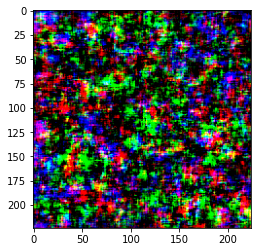

In [15]:
# this runs the counterfactual function
counterfactuals = counterfactual_regressor_only(
            X,
            y,
            target,
            regression_model,
            new_L=False,
            lambda_target=100,
            lr=0.001,
            iterations=20_000,
            )

# this is for visualisation
img = decoder.float()(counterfactuals.float())
recon=img.cpu().detach().numpy().squeeze().transpose(1,2,0)
plt.imshow(recon) 